In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# -----------------------------
# 1. Load the dataset
# -----------------------------
# Make sure the file "mindx test dataset.csv" is in your Jupyter working directory
# If it's elsewhere, change the path accordingly
df = pd.read_csv('mindx test dataset.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())  # Quick preview

Dataset loaded: 1440 rows, 10 columns


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [2]:
# 2. Fleet-wide average GHG intensity & 2026 target
# -----------------------------
total_co2 = df['CO2_emissions'].sum()
total_distance = df['distance'].sum()

average_intensity = total_co2 / total_distance
target_intensity = average_intensity * 0.95   # 5% reduction for 2026

print(f"Fleet total CO₂ emissions : {total_co2:,.2f} kg")
print(f"Fleet total distance     : {total_distance:,.2f} units")
print(f"\nDataset Average GHG Intensity : {average_intensity:.4f} kg CO₂ per unit distance")
print(f"2026 Regulatory Target Intensity: {target_intensity:.4f} kg CO₂ per unit distance")

Fleet total CO₂ emissions : 19,246,255.03 kg
Fleet total distance     : 218,524.83 units

Dataset Average GHG Intensity : 88.0735 kg CO₂ per unit distance
2026 Regulatory Target Intensity: 83.6699 kg CO₂ per unit distance


In [3]:
# -----------------------------
# 3. Per-vessel GHG intensity & compliance classification
# -----------------------------
vessel_summary = df.groupby('ship_id').agg(
    total_distance=('distance', 'sum'),
    total_co2=('CO2_emissions', 'sum'),
    trips=('distance', 'count'),
    ship_type=('ship_type', 'first')  # all trips of a vessel have same type
).reset_index()

vessel_summary['intensity'] = vessel_summary['total_co2'] / vessel_summary['total_distance']
vessel_summary['status'] = np.where(
    vessel_summary['intensity'] < target_intensity,
    'Surplus',   # below target → good / surplus credits
    'Deficit'    # above target → needs improvement
)

# Counts
surplus_count = (vessel_summary['status'] == 'Surplus').sum()
deficit_count = (vessel_summary['status'] == 'Deficit').sum()

print(f"\nCompliance Balance (as of January 2026):")
print(f"   • Surplus vessels (compliant) : {surplus_count}")
print(f"   • Deficit vessels (non-compliant): {deficit_count}")

# Show the full table (sorted by intensity)
vessel_summary_sorted = vessel_summary.sort_values('intensity').round(4)
display(vessel_summary_sorted)


Compliance Balance (as of January 2026):
   • Surplus vessels (compliant) : 68
   • Deficit vessels (non-compliant): 52


,ship_id,total_distance,total_co2,trips,ship_type,intensity,status
60,NG061,1473.43,54643.75,12,Surfer Boat,37.0861,Surplus
12,NG013,1197.84,44925.79,12,Surfer Boat,37.5057,Surplus
3,NG004,1498.23,57087.30,12,Surfer Boat,38.1032,Surplus
33,NG034,1373.27,53090.74,12,Surfer Boat,38.6601,Surplus
27,NG028,1547.61,59862.87,12,Surfer Boat,38.6808,Surplus
...,...,...,...,...,...,...,...
107,NG108,2923.20,343111.57,12,Tanker Ship,117.3753,Deficit
59,NG060,3279.00,387760.48,12,Tanker Ship,118.2557,Deficit
90,NG091,3558.63,423121.16,12,Tanker Ship,118.9000,Deficit
31,NG032,3115.20,376326.73,12,Tanker Ship,120.8034,Deficit


In [4]:
# -----------------------------
# 4. Predictive model: CO₂ = f(ship_type, distance, fuel_consumption)
# -----------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# One-hot encode ship_type
df_encoded = pd.get_dummies(df[['ship_type', 'distance', 'fuel_consumption', 'CO2_emissions']], 
                            columns=['ship_type'], drop_first=False)

X = df_encoded.drop('CO2_emissions', axis=1)
y = df_encoded['CO2_emissions']

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predictions & error
preds = model.predict(X)
mae = mean_absolute_error(y, preds)

print("\nPredictive Model Coefficients")
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coef_df.loc[len(coef_df)] = ['intercept', model.intercept_]
display(coef_df.round(4))

print(f"Mean Absolute Error on training data: {mae:,.2f} kg CO₂")


Predictive Model Coefficients


,Feature,Coefficient
0,distance,0.2074
1,fuel_consumption,2.7575
2,ship_type_Fishing Trawler,6.5663
3,ship_type_Oil Service Boat,-28.8537
4,ship_type_Surfer Boat,-15.4732
5,ship_type_Tanker Ship,37.7605
6,intercept,-24.2842


Mean Absolute Error on training data: 616.66 kg CO₂


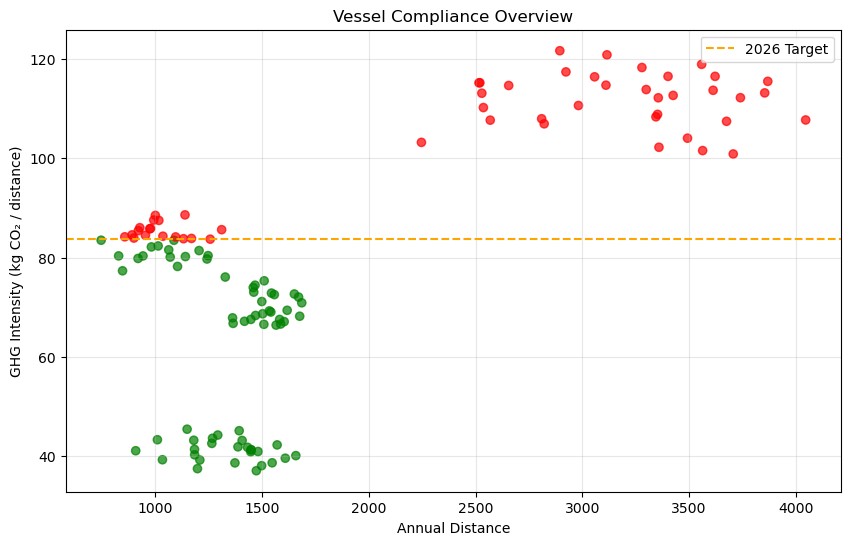

In [5]:
# -----------------------------
# 5. Quick visualisation (optional)
# -----------------------------
plt.figure(figsize=(10,6))
plt.scatter(vessel_summary['total_distance'], vessel_summary['intensity'], 
            c=vessel_summary['status'].map({'Surplus':'green', 'Deficit':'red'}), alpha=0.7)
plt.axhline(target_intensity, color='orange', linestyle='--', label='2026 Target')
plt.xlabel('Annual Distance')
plt.ylabel('GHG Intensity (kg CO₂ / distance)')
plt.title('Vessel Compliance Overview')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()